# 9. Logistic regression

In [1]:
import numpy as np
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
import math
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer

In [2]:
#mute future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#load metadata
data = pd.read_csv("data/metadata/selection_sharp.csv")
path = data["crop_storage"]

## First classification pool

- LogisticRegression has a parameter `class_weight` to deal with the problem of class imbalance.
- I tried to standardize the features extracted from the images. The drop in precision is not as important as for knn, but still present, that's why this step is not retained in the final preprocessing setup.
- I've tried `ovr` and multinomial strategies. The best result is obtained with the multinomial strategy and the `newton-cg` solver. The sag solver does not achieve convergence. However, the differences in accuray are minimal and certainly due to this particular composition of the test set.

In [4]:
#define sets (add header=None for labels since there is no column name and turn to Series)
X_tr = pd.read_csv("data/features/pool1/X_tr.csv", index_col=0)
y_tr = pd.Series(pd.read_csv("data/features/pool1/y_tr.csv", header=None, index_col=0)[1])
X_va = pd.read_csv("data/features/pool1/X_va.csv", index_col=0)
y_va = pd.Series(pd.read_csv("data/features/pool1/y_va.csv", header=None, index_col=0)[1])
X_te = pd.read_csv("data/features/pool1/X_te.csv", index_col=0)
y_te = pd.Series(pd.read_csv("data/features/pool1/y_te.csv", header=None, index_col=0)[1])

In [5]:
#concatenate train and validation set into X and y variables
X_cv = pd.concat((X_tr,X_va))
y_cv = pd.concat((y_tr,y_va))

In [6]:
#define statistical data type of columns 
cat_columns = ['Month']
num_columns = list(range(300))

#define categorical transformer
cat_transformer = OneHotEncoder(sparse=False)

#define the log transformer
log_transformer = FunctionTransformer(np.log1p)

#define the column transformer
preprocessor = ColumnTransformer([
('categorical', cat_transformer, cat_columns),
("log", log_transformer, ["altitude"]),    
("scale_log", StandardScaler(), ["altitude"])
], remainder='passthrough')

In [7]:
#create a pipeline with a scaler and a logistic regression
lr = Pipeline([
 ('preprocessor', preprocessor),
 ('logreg', LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight="balanced"))
 ])

cv_fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

#create a cross-validation object
grid = {
 'logreg__C': np.logspace(-6, 6, num=20)
 }
lr_grid_cv = GridSearchCV(lr, grid, cv=cv_fold, return_train_score=True, iid=False)

In [8]:
#fit the model with the array containing train and validation sets
lr_grid_cv.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('categorical', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
    ...         random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'logreg__C': array([1.00000e-06, 4.28133e-06, 1.83298e-05, 7.84760e-05, 3.35982e-04,
       1.43845e-03, 6.15848e-03, 2.63665e-02, 1.12884e-01, 4.83293e-01,
       2.06914e+00, 8.85867e+00, 3.79269e+01, 1.62378e+02, 6.95193e+02,
       2.97635e+03, 1.27427e+04, 5.45559e+04, 2.33572e+05, 1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=T

In [9]:
# Collect results in a DataFrame
lr_cv_results = pd.DataFrame(lr_grid_cv.cv_results_)

#keep only train and validation accuracy and the related value of C
cols = ['mean_test_score', 'mean_train_score', 'param_logreg__C']
lr_results = lr_cv_results[cols]
lr_results.columns = ['validation_accuracy', 'train_accuracy', 'C']
lr_results.set_index("C", inplace=True)

lr_results.sort_values(by='validation_accuracy', ascending=False).head()

,validation_accuracy,train_accuracy
C,,
0.006158,0.953633,0.982297
0.026367,0.950475,0.994099
2.069138,0.949420,1.000000
0.483293,0.949420,1.000000
8.858668,0.948372,1.000000


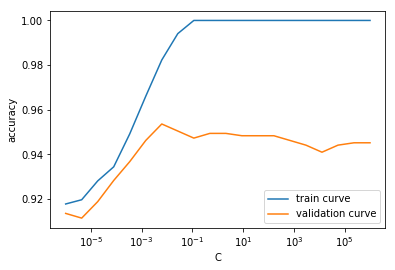

In [10]:
# Plot the validation curves
plt.semilogx(lr_results.index, lr_results['train_accuracy'], label='train curve')
plt.semilogx(lr_results.index, lr_results['validation_accuracy'], label='validation curve')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.legend()
plt.show()

In [11]:
#compute the test accuracy
#note that the best C parameter is automatically used
lr_te_accuracy1 = lr_grid_cv.score(X_te, y_te)
lr_te_accuracy1

0.957983193277311

100%|██████████| 10/10 [00:00<00:00, 172.51it/s]


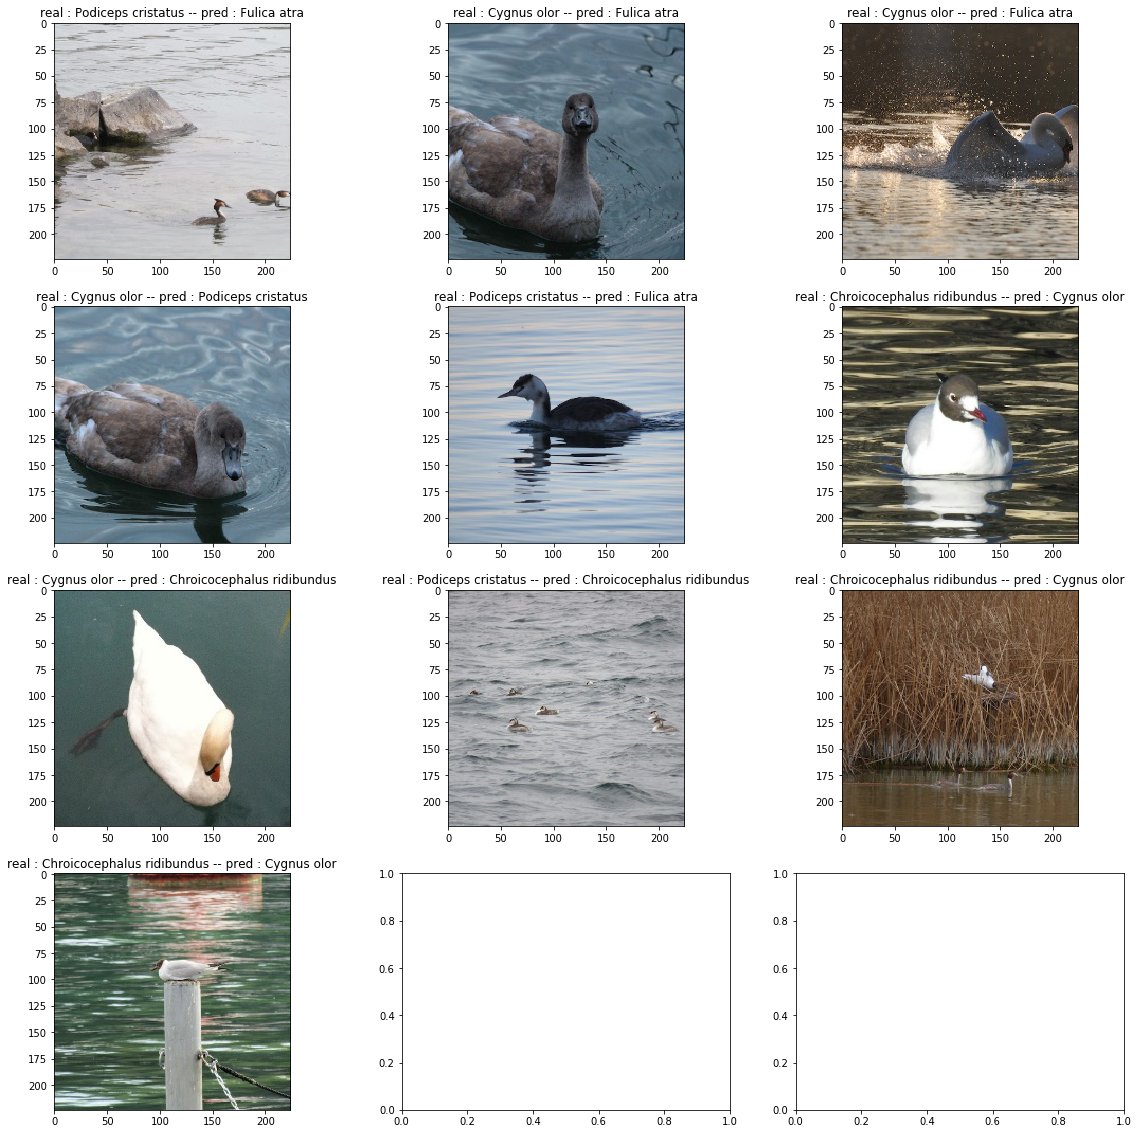

In [12]:
#use our trained model to make predictions on the features of the test set
te_pred = lr_grid_cv.predict(X_te)
#get the index of misclassified images
failed_te_knn = y_te[te_pred!=y_te].index
#define number of misclassified specimens
n = len(failed_te_knn)

#plot the missclassified images of the test set
fig,axes = plt.subplots(nrows=math.ceil(n/3), ncols=3)
fig.set_figwidth(20)
fig.set_figheight(n*2)

for i in tqdm(range(0,len(failed_te_knn))):
    #define current index
    currid = failed_te_knn[i]
    #get pixel array of misclassified images
    np_img = np.array(Image.open(path[currid]))
    #plot the images
    axes.ravel()[i].imshow(np_img)
    #find the real class of the image
    failed_te_real_class = y_te[failed_te_knn[i]]
    #find the wrong predicted class
    failed_te_wrong_class = te_pred[te_pred!=y_te][i]
    #print the real and wrong classes of misclassified images
    axes.ravel()[i].set_title("real : {} -- pred : {}".format(failed_te_real_class, failed_te_wrong_class))

plt.show()

In [13]:
failed_te_knn

Int64Index([141, 1089, 1112, 1084, 14, 637, 1080, 151, 753, 663], dtype='int64', name=0)

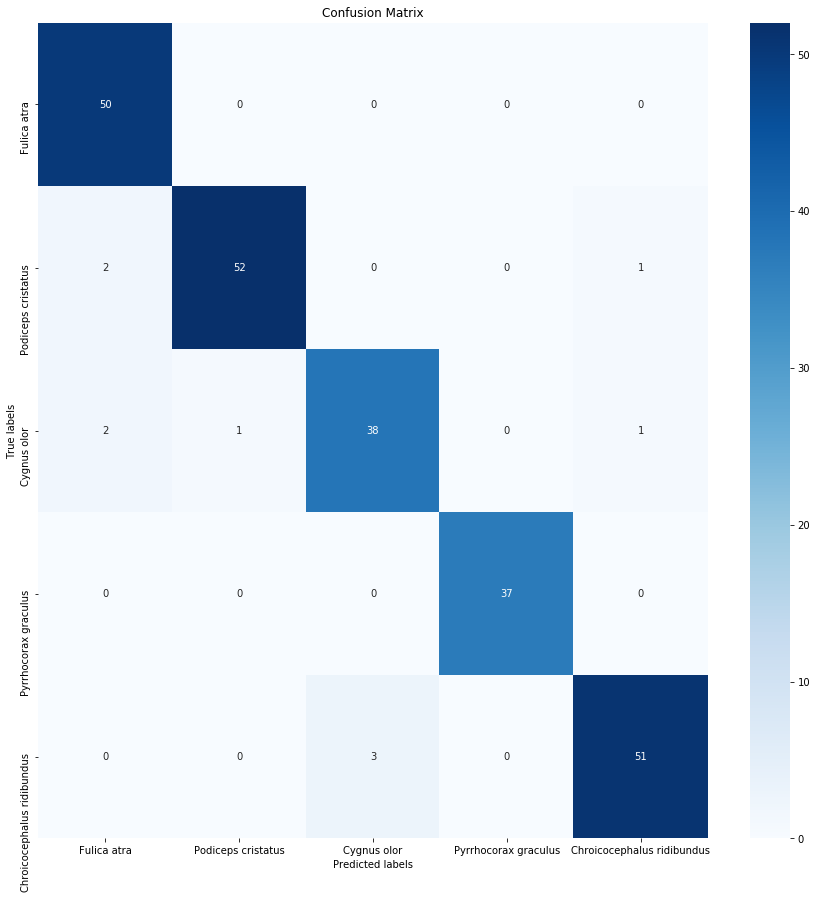

In [14]:
#use our trained model to make predictions on the features of the test set
te_pred = lr_grid_cv.predict(X_te)

#get the true labels of misclassified observations
failed_te_knn_true = y_te[te_pred!=y_te]

#get the predicted labels of misclassified observations
failed_te_knn_pred = pd.Series(te_pred[te_pred!=y_te], index=failed_te_knn_true.index)

#concatenate into a single dataframe
failed_te_knn1 = pd.concat([failed_te_knn_true,failed_te_knn_pred], axis=1)
failed_te_knn1.columns = ["true", "predicted"]

#define confusion matrix
cm = confusion_matrix(y_te, te_pred, labels=y_te.unique())

#plot it with seaborn
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
ax.set_ylabel('True labels')
ax.set_xlabel('Predicted labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(y_te.unique())
ax.yaxis.set_ticklabels(y_te.unique())
plt.show()

## Second classification pool
- The general characteristics specific to logistic regression are also valid for the second classification pool.
- For the second classification pool, the best result is obtained with the `ovr` strategy and the solver `liblinear`. However, the differences in accuray are minimal and certainly due to this particular composition of the test set.

In [15]:
#define sets (add header=None for labels since there is no column name and turn to Series)
X_tr = pd.read_csv("data/features/pool2/X_tr.csv", index_col=0)
y_tr = pd.Series(pd.read_csv("data/features/pool2/y_tr.csv", header=None, index_col=0)[1])
X_va = pd.read_csv("data/features/pool2/X_va.csv", index_col=0)
y_va = pd.Series(pd.read_csv("data/features/pool2/y_va.csv", header=None, index_col=0)[1])
X_te = pd.read_csv("data/features/pool2/X_te.csv", index_col=0)
y_te = pd.Series(pd.read_csv("data/features/pool2/y_te.csv", header=None, index_col=0)[1])

In [16]:
#concatenate train and validation set into X and y variables
X_cv = pd.concat((X_tr,X_va))
y_cv = pd.concat((y_tr,y_va))

In [17]:
#define statistical data type of columns 
cat_columns = ['Month']
num_columns = list(range(300))

#define categorical transformer
cat_transformer = OneHotEncoder(sparse=False)

#define the log transformer
log_transformer = FunctionTransformer(np.log1p)

#define the column transformer
preprocessor = ColumnTransformer([
('categorical', cat_transformer, cat_columns),
("log", log_transformer, ["altitude"]),    
("scale_log", StandardScaler(), ["altitude"])
], remainder='passthrough')

In [18]:
#create a pipeline with a scaler and a logistic regression
lr = Pipeline([
 ('preprocessor', preprocessor),
 ('logreg', LogisticRegression(multi_class='ovr', solver='liblinear', class_weight="balanced"))
 ])

cv_fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

#create a cross-validation object
grid = {
 'logreg__C': np.logspace(-6, 6, num=20)
 }
lr_grid_cv = GridSearchCV(lr, grid, cv=cv_fold, return_train_score=True, iid=False)

In [19]:
#fit the model with the array containing train and validation sets
lr_grid_cv.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('categorical', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
    ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'logreg__C': array([1.00000e-06, 4.28133e-06, 1.83298e-05, 7.84760e-05, 3.35982e-04,
       1.43845e-03, 6.15848e-03, 2.63665e-02, 1.12884e-01, 4.83293e-01,
       2.06914e+00, 8.85867e+00, 3.79269e+01, 1.62378e+02, 6.95193e+02,
       2.97635e+03, 1.27427e+04, 5.45559e+04, 2.33572e+05, 1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=T

In [20]:
# Collect results in a DataFrame
lr_cv_results = pd.DataFrame(lr_grid_cv.cv_results_)

#keep only train and validation accuracy and the related value of C
cols = ['mean_test_score', 'mean_train_score', 'param_logreg__C']
lr_results = lr_cv_results[cols]
lr_results.columns = ['validation_accuracy', 'train_accuracy', 'C']
lr_results.set_index("C", inplace=True)

lr_results.sort_values(by='validation_accuracy', ascending=False).head()

,validation_accuracy,train_accuracy
C,,
0.112884,0.948930,0.998541
0.026367,0.944037,0.987834
0.483293,0.940378,1.000000
2.069138,0.937927,1.000000
0.006158,0.937927,0.978102


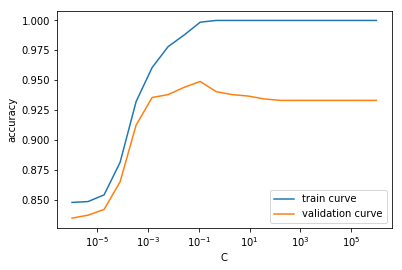

In [21]:
# Plot the validation curves
plt.semilogx(lr_results.index, lr_results['train_accuracy'], label='train curve')
plt.semilogx(lr_results.index, lr_results['validation_accuracy'], label='validation curve')
plt.ylabel('accuracy')
plt.xlabel('C')
plt.legend()
plt.show()

In [22]:
#compute the test accuracy
#note that the best C parameter is automatically used
lr_te_accuracy2 = lr_grid_cv.score(X_te, y_te)
lr_te_accuracy2

0.9514563106796117

100%|██████████| 10/10 [00:00<00:00, 198.46it/s]


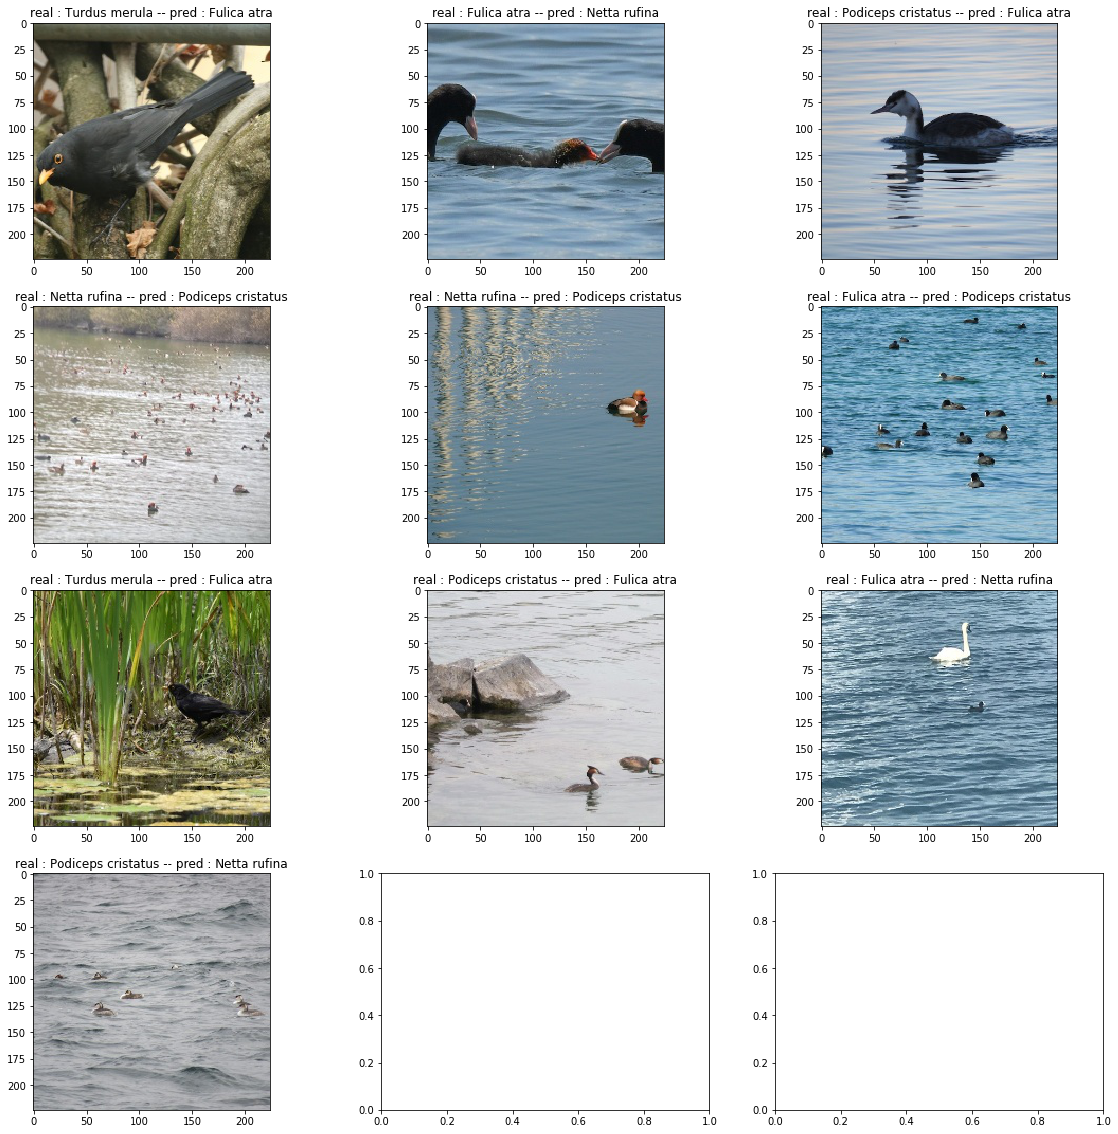

In [23]:
#use our trained model to make predictions on the features of the test set
te_pred = lr_grid_cv.predict(X_te)
#get the index of misclassified images
failed_te_knn = y_te[te_pred!=y_te].index
#define number of misclassified specimens
n = len(failed_te_knn)

#plot the missclassified images of the test set
fig,axes = plt.subplots(nrows=math.ceil(n/3), ncols=3)
fig.set_figwidth(20)
fig.set_figheight(n*2)

for i in tqdm(range(0,len(failed_te_knn))):
    #define current index
    currid = failed_te_knn[i]
    #get pixel array of misclassified images
    np_img = np.array(Image.open(path[currid]))
    #plot the images
    axes.ravel()[i].imshow(np_img)
    #find the real class of the image
    failed_te_real_class = y_te[failed_te_knn[i]]
    #find the wrong predicted class
    failed_te_wrong_class = te_pred[te_pred!=y_te][i]
    #print the real and wrong classes of misclassified images
    axes.ravel()[i].set_title("real : {} -- pred : {}".format(failed_te_real_class, failed_te_wrong_class))

plt.show()

In [24]:
failed_te_knn

Int64Index([1442, 344, 14, 812, 930, 408, 1454, 141, 380, 151], dtype='int64', name=0)

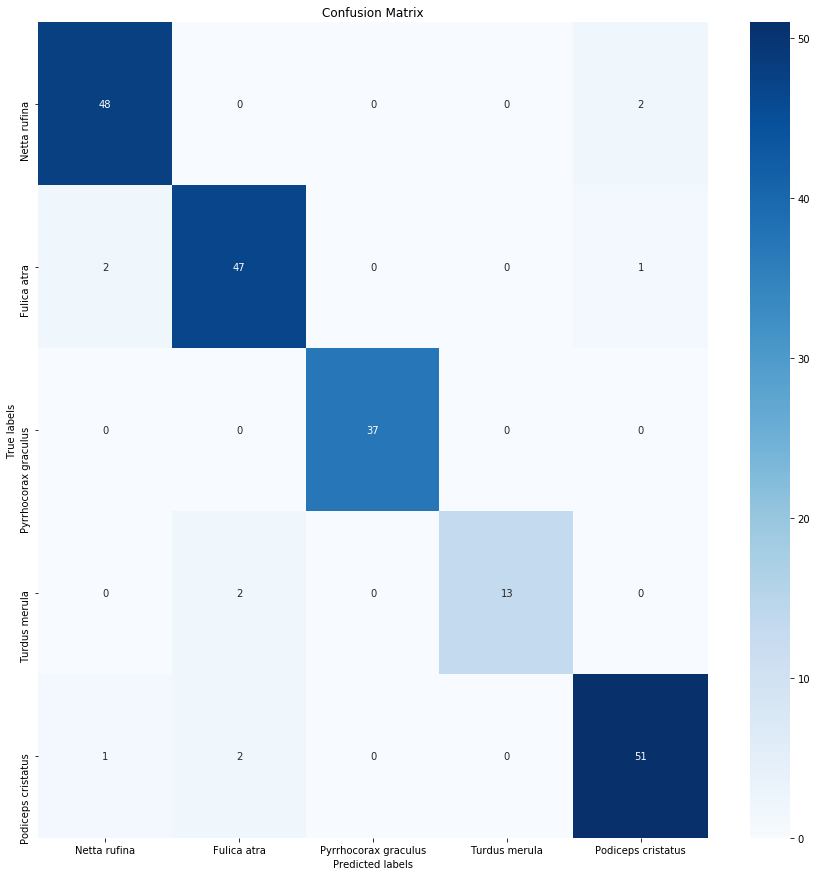

In [25]:
#use our trained model to make predictions on the features of the test set
te_pred = lr_grid_cv.predict(X_te)

#get the true labels of misclassified observations
failed_te_knn_true = y_te[te_pred!=y_te]

#get the predicted labels of misclassified observations
failed_te_knn_pred = pd.Series(te_pred[te_pred!=y_te], index=failed_te_knn_true.index)

#concatenate into a single dataframe
failed_te_knn1 = pd.concat([failed_te_knn_true,failed_te_knn_pred], axis=1)
failed_te_knn1.columns = ["true", "predicted"]

#define confusion matrix
cm = confusion_matrix(y_te, te_pred, labels=y_te.unique())

#plot it with seaborn
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
ax.set_ylabel('True labels')
ax.set_xlabel('Predicted labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(y_te.unique())
ax.yaxis.set_ticklabels(y_te.unique())
plt.show()

In [26]:
#summarise results
lr_results = pd.Series([lr_te_accuracy1,lr_te_accuracy2],["Logistic regression Pool 1","Logistic regression Pool 2",])
lr_results

Logistic regression Pool 1    0.957983
Logistic regression Pool 2    0.951456
dtype: float64

In [27]:
#save results
lr_results.to_csv("data/results/lr.csv")